In [54]:
import torch
import torch.nn as nn
import torch_geometric
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
def solve_quadratic(a, b, c):
    if a == 0:
        if b == 0:
            return None
        return -c/b
    D = b * b - 4 * a * c
    if D >= 0:
        return (-b + (D ** 0.5)) / (2 * a)
    return None

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class GNN_Layer(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            activation_function
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation_function = activation_function

        self.W_self = nn.Linear(in_features = in_features, out_features = out_features, bias = False)
        self.W_neigh = nn.Linear(in_features = in_features, out_features = out_features, bias = True)
    def forward(self, X, A):
        return self.activation_function(self.W_self.forward(X) + self.W_neigh.forward(torch.matmul(A, X)))
    
    def reset_parameters(self):
        self.W_self.reset_parameters()
        self.W_neigh.reset_parameters()

class MLP_Layer(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            activation_function
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation_function = activation_function

        self.W = nn.Linear(in_features = in_features, out_features = out_features, bias = True)
    def forward(self, X, **kwargs):
        return self.activation_function(self.W.forward(X))
    
    
    def reset_parameters(self):
        self.W.reset_parameters()
    
class GNN(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            num_layers: int,
            target_num_parameters: int,
            activation_function
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation_function = activation_function

        if num_layers > 1:
            a = 2 * num_layers - 4
            b = 2 * in_features + 2 * out_features + num_layers - 1
            c = out_features - target_num_parameters

            hidden_features = solve_quadratic(a, b, c)
            if hidden_features:
                hidden_features = max(1, int(hidden_features))
            else:
                hidden_features = 1
        else:
            hidden_features = None
        
        self.layers = nn.ModuleList(
            [GNN_Layer(
                in_features = in_features if i == 0 else hidden_features, 
                out_features = out_features if i == num_layers - 1 else hidden_features, 
                activation_function=activation_function) for i in range(num_layers)])
        
        if num_layers > 1:
            assert (number_of_parameters(self) == (2 * in_features + 1) * hidden_features + (2 * hidden_features + 1) * out_features + (num_layers - 2) * (2 * hidden_features + 1) * hidden_features)
        print(f"GNN: Hidden features set to {hidden_features}. Model has {number_of_parameters(self)} trainable parameters")

    def forward(self, X, A):
        for layer in self.layers:
            X = layer.forward(X, A)
        return X
    
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

class MLP(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            num_layers: int,
            target_num_parameters: int,
            activation_function
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation_function = activation_function

        
        if num_layers > 1:
            a = num_layers - 2
            b = in_features + out_features + num_layers - 1
            c = out_features - target_num_parameters

            hidden_features = solve_quadratic(a, b, c)
            if hidden_features:
                hidden_features = max(1, int(hidden_features))
            else:
                hidden_features = 1
        else:
            hidden_features = None

        self.layers = nn.ModuleList([MLP_Layer(
                in_features = in_features if i == 0 else hidden_features, 
                out_features = out_features if i == num_layers - 1 else hidden_features, 
                activation_function=activation_function) for i in range(num_layers)])

        if num_layers > 1:
            assert (number_of_parameters(self) == (in_features + 1) * hidden_features + (hidden_features + 1) * out_features + (num_layers - 2) * (hidden_features + 1) * hidden_features)
        print(f"MLP: Hidden features set to {hidden_features}. Model has {number_of_parameters(self)} trainable parameters")

    def forward(self, X, **kwargs):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
    
class GNN_interleaved(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            num_layers: int,
            target_num_parameters: int,
            activation_function
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation_function = activation_function

        a = 3 * num_layers - 3
        b = 2 * in_features + out_features + 2 * num_layers - 1
        c = out_features - target_num_parameters

        hidden_features = solve_quadratic(a, b, c)
        if hidden_features:
            hidden_features = max(1, int(hidden_features))
        else:
            hidden_features = 1
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(GNN_Layer(
                in_features = in_features if i == 0 else hidden_features, 
                out_features = hidden_features, 
                activation_function=activation_function))
            self.layers.append(MLP_Layer(
                in_features = hidden_features, 
                out_features = out_features if i == num_layers - 1 else hidden_features, 
                activation_function=activation_function))
        
        if num_layers > 1:
            assert (number_of_parameters(self) == (2 * in_features + 1) * hidden_features + (hidden_features + 1) * out_features + (num_layers - 1) * ((2 * hidden_features + 1) * hidden_features + (hidden_features + 1) * hidden_features))
        print(f"GNN_interleaved: Hidden features set to {hidden_features}. Model has {number_of_parameters(self)} trainable parameters")

    def forward(self, X, A):
        for layer in self.layers:
            X = layer.forward(X = X, A = A)
        return X
    
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

class GNN_with_MLP_readout(nn.Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            num_layers: int,
            target_num_parameters: int,
            activation_function
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation_function = activation_function

        a = 3 * num_layers - 3
        b = 2 * in_features + out_features + 2 * num_layers - 1
        c = out_features - target_num_parameters

        hidden_features = solve_quadratic(a, b, c)
        if hidden_features:
            hidden_features = max(1, int(hidden_features))
        else:
            hidden_features = 1
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(GNN_Layer(
                in_features = in_features if i == 0 else hidden_features, 
                out_features = hidden_features, 
                activation_function=activation_function))
        for i in range(num_layers):
            self.layers.append(MLP_Layer(
                in_features = hidden_features, 
                out_features = out_features if i == num_layers - 1 else hidden_features, 
                activation_function=activation_function))
        
        if num_layers > 1:
            assert (number_of_parameters(self) == (2 * in_features + 1) * hidden_features + (hidden_features + 1) * out_features + (num_layers - 1) * ((2 * hidden_features + 1) * hidden_features + (hidden_features + 1) * hidden_features))
        print(f"GNN_with_MLP_readout: Hidden features set to {hidden_features}. Model has {number_of_parameters(self)} trainable parameters")

    def forward(self, X, A):
        for layer in self.layers:
            X = layer.forward(X = X, A = A)
        return X
    
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

In [59]:
class GraphDataset():
    def __init__(self, X, A, y):
        self.X = X
        self.A = A
        self.y = y
        self.n_nodes = y.size()[0]

    def split(self, mask):
        return GraphDataset(self.X[mask], self.A[mask][:, mask], self.y[mask]), GraphDataset(self.X[~mask], self.A[~mask][:, ~mask], self.y[~mask])
    def to(self, device):
        self.X = self.X.to(device)
        self.A = self.A.to(device)
        self.y = self.y.to(device)


def train_epoch(data, mask, model, loss_fn, optimiser):
    """Do one epoch-worth of training."""

    model.train()

    optimiser.zero_grad()

    pred = model(X = data.X, A = data.A)

    loss = loss_fn(pred[mask], data.y[mask])

    loss.backward()

    optimiser.step()

def train(data, train_mask, test_mask, model, loss_fn, optimiser,
          epochs=200):
    """Train a model for a certain number of epochs."""

    train_accuracies = []
    test_accuracies = []

    for t in range(1, epochs+1):

        train_epoch(data, train_mask, model, loss_fn, optimiser)

        test_accuracies.append(test(data, test_mask, model))
        train_accuracies.append(test(data, train_mask, model))
    
    return test_accuracies, train_accuracies

def test(data, mask, model):
    """Test a model on some data."""

    model.eval()

    with torch.no_grad():
        pred = model(X = data.X, A = data.A).argmax(1)

        accuracy = torch.mean((pred[mask] == data.y[mask]).float())
    return accuracy.item()

def cross_validate(data, model, loss_fn, optimiser, num_splits=5,
                   epochs=200):
    """Use k-fold cross validation to evaluate a model on a dataset.

    """
    data.to(device)
    model.to(device)

    ids = list(range(data.n_nodes))
    random.shuffle(ids)

    train_accuracies_ = []
    test_accuracies_ = []
    for fold in tqdm(range(num_splits)):

        index_min = int(((data.n_nodes * fold) // num_splits))
        index_max = int(((data.n_nodes * (fold+1)) // num_splits))

        mask = torch.zeros(data.n_nodes, dtype = torch.bool)
        mask[ids[index_min:index_max]] = True

        train_mask, test_mask = ~mask, mask

        model.reset_parameters()

        test_accuracies, train_accuracies = train(data, train_mask, test_mask, model, loss_fn, optimiser, epochs)
        test_accuracies_.append(test_accuracies)
        train_accuracies_.append(train_accuracies)
    test_accuracies_ = np.array(test_accuracies_)
    train_accuracies_ = np.array(train_accuracies_)

    test_mean = np.mean(test_accuracies_, axis = 0)
    test_std = np.std(test_accuracies_, axis = 0)
    train_mean = np.mean(train_accuracies_, axis = 0)
    train_std = np.std(train_accuracies_, axis = 0)

    data.to('cpu')
    model.to('cpu')
    return (test_mean, test_std), (train_mean, train_std)



In [57]:

datasets = {
    name: torch_geometric.datasets.Planetoid(
        root="./",
        name=name,
        split="public")
    for name in ["Cora", "CiteSeer", "PubMed"]
        
}

model_list = {"GNN_interleaved": GNN_interleaved,
              "GNN_with_MLP_readout": GNN_with_MLP_readout,
              "GNN": GNN,
              "MLP": MLP}


Cora
GNN_interleaved: Hidden features set to 33. Model has 98182 trainable parameters
98182


100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


Test accuracy 0.7818040311336517+-0.07038495366977045. Train accuracy 0.8817017555236817+-0.08794974325120121
GNN_with_MLP_readout: Hidden features set to 33. Model has 98182 trainable parameters
98182


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Test accuracy 0.7716482222080231+-0.14799267637528593. Train accuracy 0.8734792768955231+-0.16695631915876916
GNN: Hidden features set to 34. Model has 97961 trainable parameters
97961


100%|██████████| 10/10 [00:59<00:00,  5.93s/it]


Test accuracy 0.8522973895072937+-0.028063701250258984. Train accuracy 0.9669267356395721+-0.04070260911524935
MLP: Hidden features set to 69. Model has 99436 trainable parameters
99436


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Test accuracy 0.6986907243728637+-0.042238386241209916. Train accuracy 0.971522456407547+-0.05668031360740321


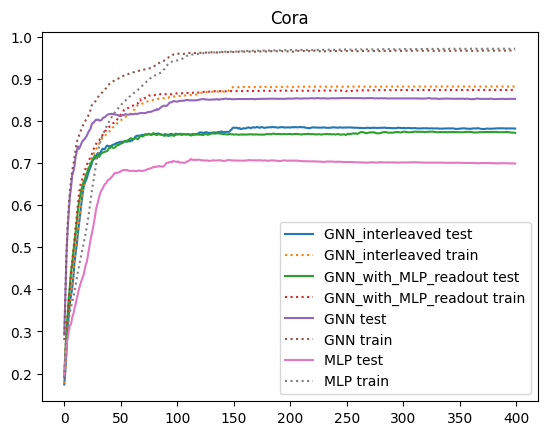

CiteSeer
GNN_interleaved: Hidden features set to 13. Model has 96908 trainable parameters
96908


100%|██████████| 10/10 [02:05<00:00, 12.54s/it]


Test accuracy 0.700356388092041+-0.058682926808396575. Train accuracy 0.9575158536434174+-0.07462878003780042
GNN_with_MLP_readout: Hidden features set to 13. Model has 96908 trainable parameters
96908


100%|██████████| 10/10 [01:55<00:00, 11.58s/it]


Test accuracy 0.67751185297966+-0.05579304193875184. Train accuracy 0.9300937175750732+-0.0993936495250138
GNN: Hidden features set to 13. Model has 96453 trainable parameters
96453


100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


Test accuracy 0.7303954660892487+-0.05028272994155956. Train accuracy 0.9753843963146209+-0.06078467614228519
MLP: Hidden features set to 26. Model has 96466 trainable parameters
96466


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


Test accuracy 0.6603522181510926+-0.05508527652162533. Train accuracy 0.9421920061111451+-0.08739159903477636


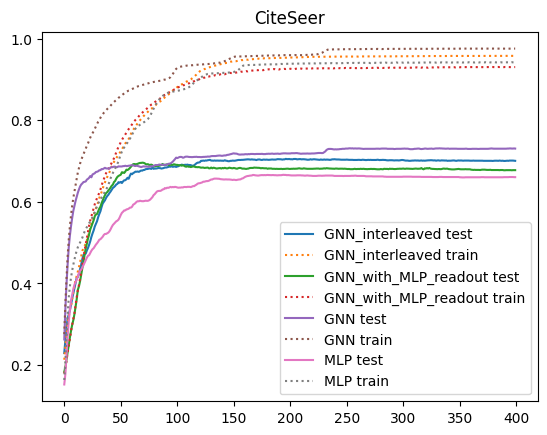

PubMed
GNN_interleaved: Hidden features set to 80. Model has 99683 trainable parameters
99683


100%|██████████| 10/10 [09:25<00:00, 56.57s/it]


Test accuracy 0.8242043316364288+-0.14022164593239833. Train accuracy 0.8823076546192169+-0.15492012738261757
GNN_with_MLP_readout: Hidden features set to 80. Model has 99683 trainable parameters
99683


100%|██████████| 10/10 [09:13<00:00, 55.34s/it]


Test accuracy 0.8543442845344543+-0.09937180885228895. Train accuracy 0.9106910645961761+-0.11455868816698689
GNN: Hidden features set to 99. Model has 99696 trainable parameters
99696


100%|██████████| 10/10 [09:43<00:00, 58.39s/it]


Test accuracy 0.8501853466033935+-0.10591655090806311. Train accuracy 0.8951604485511779+-0.11487731238491611
MLP: Hidden features set to 198. Model has 99795 trainable parameters
99795


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Test accuracy 0.7967838943004608+-0.12646527098897037. Train accuracy 0.8205372333526612+-0.12683543659278537


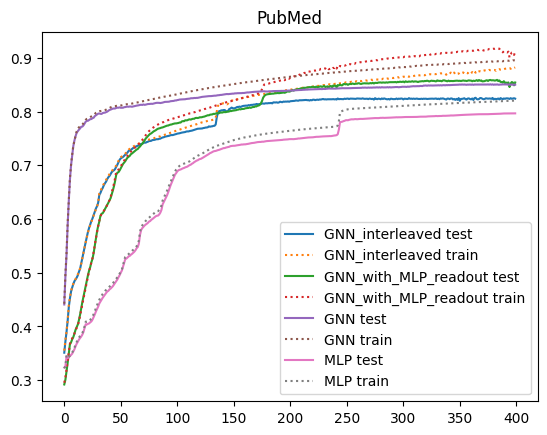

In [62]:
results = {}
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    data = GraphDataset(X = dataset.x, A = torch_geometric.utils.to_dense_adj(dataset.edge_index).squeeze(0), y = dataset.y)
    results[dataset_name] = {}
    for model_name, model in model_list.items():

        model = model(in_features = dataset.num_features, out_features = dataset.num_classes, num_layers = 2, target_num_parameters = 100000, activation_function = torch.relu)

        print(number_of_parameters(model))

        (test_mean, test_std), (train_mean, train_std) = cross_validate(data,
                    model = model,
                    loss_fn = nn.CrossEntropyLoss(ignore_index=-1),
                    optimiser = torch.optim.AdamW(params = filter(lambda p: p.requires_grad, model.parameters())),
                    num_splits = 10,
                    epochs = 400)
        plt.plot(test_mean, label = model_name + " test")
        plt.plot(train_mean, ls = ':', label = model_name+" train")
        print(f"Test accuracy {test_mean[-1]}+-{test_std[-1]}. Train accuracy {train_mean[-1]}+-{train_std[-1]}")
        results[dataset_name][model_name] = (test_mean, test_std), (train_mean, train_std)
    plt.legend()
    plt.title(dataset_name)
    plt.show()